In [17]:
import numpy as np
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
s = {
    'problem'           : "regression",
    'approach'          : "few-shot learning",
    'method'            : "non-parametric",
    'algorithm'         : "siamese network",
    'goal'              : "learn a distribution using few samples from it",
    'input'             : "samples from a distribution",
    'input type'        : "vectors",
    'input meaning'     : "spectrum", 
    'output'            : "samples from a distribution",
    'output type'       : "one number",
    'output meaning'    : "temperature or pressure, depending on distribution",
    'number of ways'    : 2,
    'number of shots'   : 1,
    'number of folds'   : 8,
    'support-query ratio': 0.8,
    'task size'         : 5,
    'learning rate'     : 1e-4,
    'input dimension'   : 10000,
    'output dimension'  : 1,
    'feature dimension' : 300,
    'epoch'             : 1000,
    'epoch development' : 4,
    'data'              : 'temperature_230509_discrete',
    'data P'            : 'pressure_230516_discrete',
    'data T'            : 'temperature_230509_discrete',
    'cross validation round': 16,
    'cross validation round-development' : 3,
    'batch size'        : 32,
    'best model folder' : 'SiameseAux_multi_T->P/'
}

In [18]:
import data_accessor as acc
data_names_list = [
    'temperature_230509_discrete',
    'pressure_230516_discrete'
    ]
data_dictionary = acc.setup(data_names_list)

loading temperature_230509_discrete__________________________
	input shape (number, dimension): (6000, 10000)
	label shape (number, dimension): (6000, 1)
	there are 16 folds
	4200 for training, 600 for validating, 1200 for testing
loading pressure_230516_discrete__________________________
	input shape (number, dimension): (5000, 10000)
	label shape (number, dimension): (5000, 1)
	there are 16 folds
	3500 for training, 500 for validating, 1000 for testing


In [19]:
import torch.nn as nn
class SingleTaskNetwork(torch.nn.Module):
    def __init__(self, device, input_dimension, feature_dimension, output_dimension):
        """ Input: input, anchor, anchor label
        Output: prediction for input"""
        super().__init__()
        self.input_dimension = input_dimension
        self.hidden_dimension = 400
        self.feature_hidden_dimension = 100
        self.feature_dimension = feature_dimension
        self.output_dimension = output_dimension
        self.device = device
        self.feature_sequential = torch.nn.Sequential(
            torch.nn.Linear(self.input_dimension, self.hidden_dimension),
            nn.ReLU(),
            torch.nn.Linear(self.hidden_dimension, self.hidden_dimension),
            nn.ReLU(),
            torch.nn.Linear(self.hidden_dimension, self.feature_dimension)
        )
        self.auxiliary_sequential = torch.nn.Sequential(
            torch.nn.Linear(self.feature_dimension, self.feature_hidden_dimension),
            nn.ReLU(),
            torch.nn.Linear(self.feature_hidden_dimension, self.feature_hidden_dimension),
            nn.ReLU(),
            torch.nn.Linear(self.feature_hidden_dimension, self.output_dimension)
        )
        self.to(device)
        self.float()
    def forward(self, input, anchor, anchor_label):
        feature_input = self.feature_sequential(input)
        feature_anchor = self.feature_sequential(anchor)
        feature_space_difference_input_from_anchor = feature_input - feature_anchor
        label_difference_input_from_anchor = self.auxiliary_sequential(feature_space_difference_input_from_anchor)
        prediction = anchor_label + label_difference_input_from_anchor
        return prediction

In [20]:
from tools import SaveBestModel, PatienceEarlyStopping, Scheduler, plot_loss
class Manager:
    """ DOES: train & evaluate a Siamese network
        """
    def __init__(self, epoch, cross_validation_round):
        self._network = SingleTaskNetwork(device, s['input dimension'], s['feature dimension'], s['output dimension'])
        self._network.apply(self.initializer)
        self._learning_rate = s['learning rate']
        self._optimizer = torch.optim.Adam(
            params=self._network.parameters(), lr=self._learning_rate,
            weight_decay=3e-3)
        self._energy = nn.MSELoss()
        self._train_loss = []
        self._valid_loss = []
        self._test_loss = []
        self._epoch = epoch
        self._stopper = PatienceEarlyStopping(patience=5, min_delta=1e-7)
        self._cross_validation_round = cross_validation_round
        self._saver = SaveBestModel(s['best model folder'])
        self._scheduler = Scheduler(optimizer=self._optimizer, 
            minimum_learning_rate=1e-6, patience=5, factor=0.5)
    def initializer(self, layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_normal_(layer.weight) # normal version
    def _step(self, job):
        input, input_label, anchor, anchor_label = job
        # print(f"input dtype is {input_1.dtype}")
        prediction = self._network(input, anchor, anchor_label)
        loss = self._energy(input_label, prediction)
        return loss     
    def train(self, train_dataloader, valid_dataloader):
        """ DOES: calculate loss from tasks
            NOTE: we have a BATCH of tasks here """
        for e in range(self._epoch):
            # print(f"train() epoch {e}")
            batch_train_loss = []
            for _, batch in enumerate(train_dataloader): 
                self._optimizer.zero_grad()
                loss = self._step(batch)
                loss.backward()
                self._optimizer.step()
                batch_train_loss.append(loss.item())
            self._train_loss.append(np.mean(batch_train_loss))
            batch_valid_loss = []
            with torch.no_grad():
                for _, batch in enumerate(valid_dataloader): 
                    loss = self._step(batch)
                    batch_valid_loss.append(loss.item())
            self._valid_loss.append(np.mean(batch_valid_loss))
            # saving, early stopping, scheduler for EACH epoch!
            self._saver(current_loss=np.mean(batch_valid_loss), 
                  model=self._network, 
                  round=self._cross_validation_round
                  )
            self._scheduler(np.mean(batch_valid_loss))
            self._stopper(np.mean(batch_valid_loss))
            if self._stopper.early_stop == True:
                print(f"EARLY STOPPING @ epoch {e}")
                break
        # summary printout, after we're done with epochs
        print(f"min train loss: {np.min(self._train_loss)}")
        print(f"min valid loss: {np.min(self._valid_loss)}")
        plot_loss(self._train_loss, self._valid_loss)
        return np.min(self._valid_loss)
    def test(self, test_dataloader):
        with torch.no_grad():
            batch_test_loss = []
            for _, batch in enumerate(test_dataloader): 
                loss = self._step(batch)
                batch_test_loss.append(loss.item())
            self._test_loss.append(np.mean(batch_test_loss)) 
        return np.min(self._test_loss)

data: temperature_230509_discrete then pressure_230516_discrete
CV round 0_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 16
min train loss: 0.00013766599479850177
min valid loss: 0.00013089556197978949


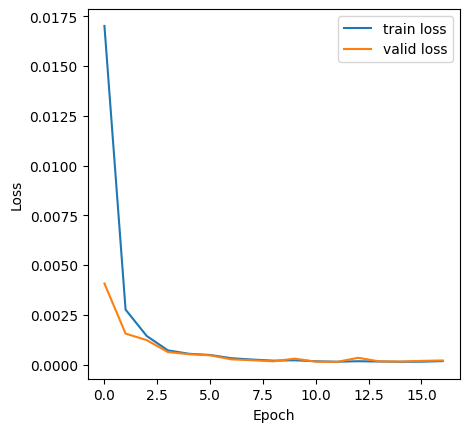

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 32
min train loss: 0.00011521455840424592
min valid loss: 0.00011537728732946562


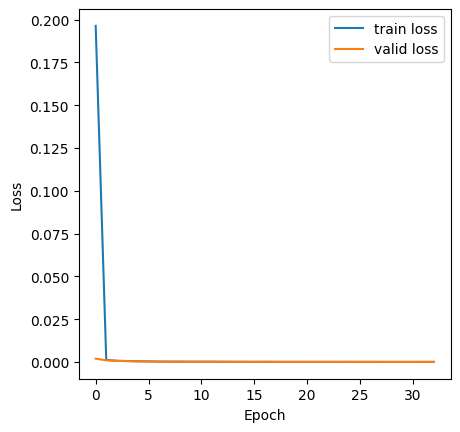

CV round 1_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 17
min train loss: 0.000136715294943177
min valid loss: 0.0001119919359457287


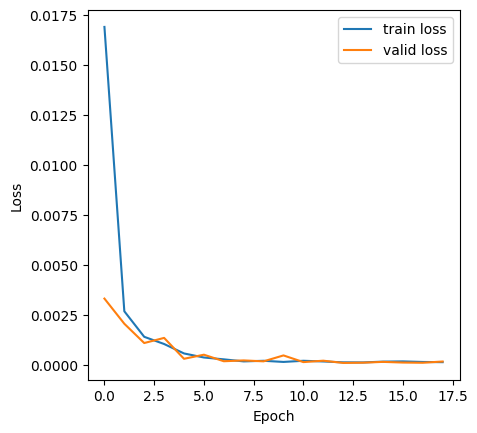

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 32
min train loss: 0.00012064694231164387
min valid loss: 0.00013193500899433275


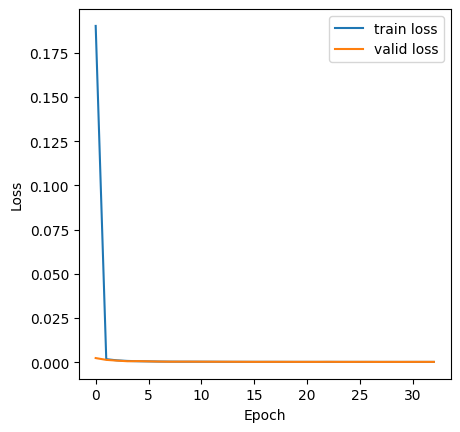

CV round 2_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 14
min train loss: 0.00013141527894979598
min valid loss: 0.00015762212474089066


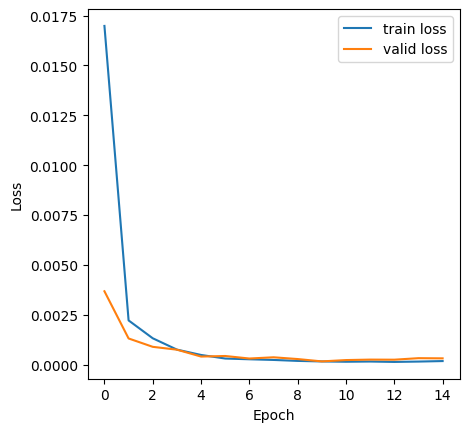

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 27
min train loss: 0.00013210019017358056
min valid loss: 0.00012210213731123076


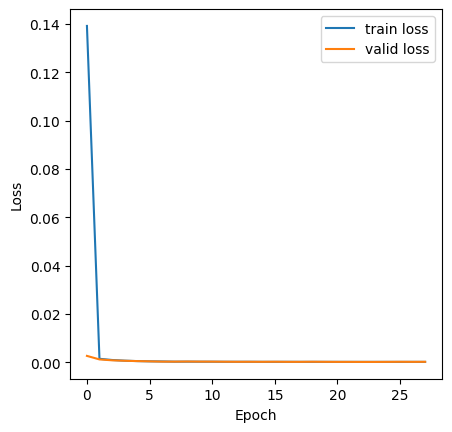

CV round 3_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 16
min train loss: 0.00014504586262332987
min valid loss: 0.0002266138962065605


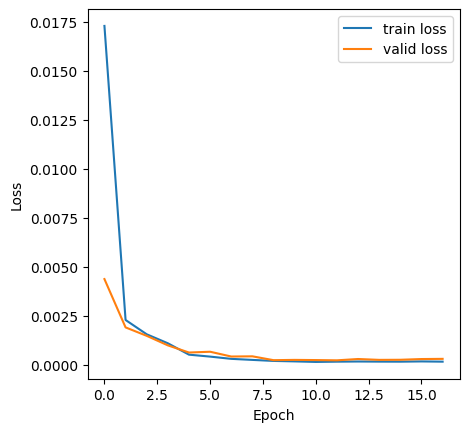

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 25
min train loss: 0.0001472836044161919
min valid loss: 0.00013235767983132973


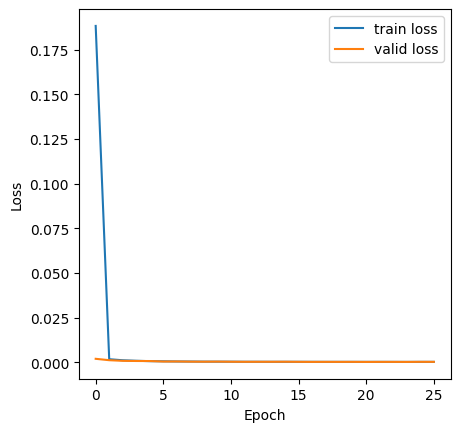

CV round 4_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 21
min train loss: 0.00014544910118274856
min valid loss: 0.00012293473704822215


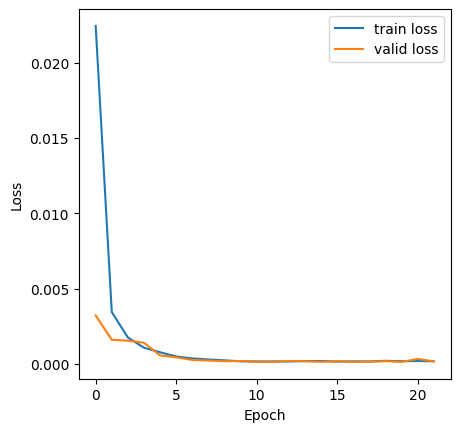

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 36
min train loss: 0.0001660972537634238
min valid loss: 0.00015404410260089207


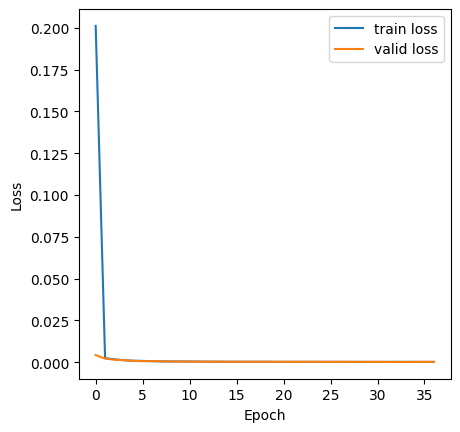

CV round 5_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 15
min train loss: 0.00014881005947906735
min valid loss: 0.00012107998056882552


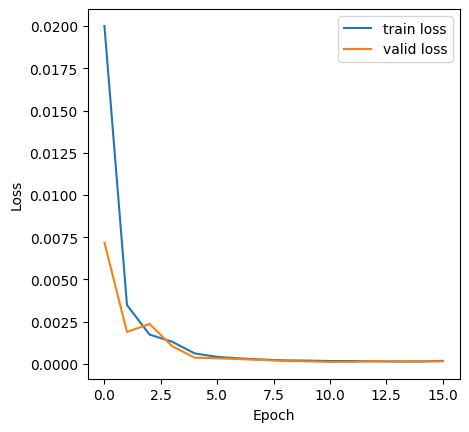

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 23
min train loss: 0.00010629320844269718
min valid loss: 9.223171105077199e-05


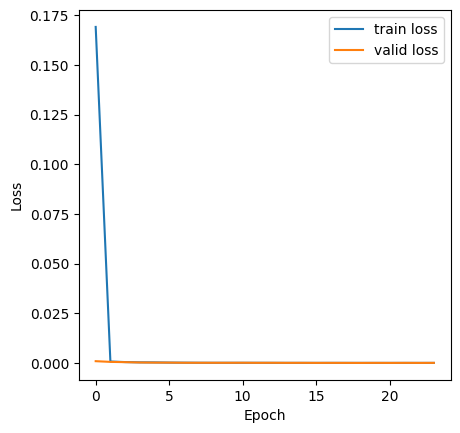

CV round 6_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 24
min train loss: 0.0001380067114951089
min valid loss: 0.00013928929700724488


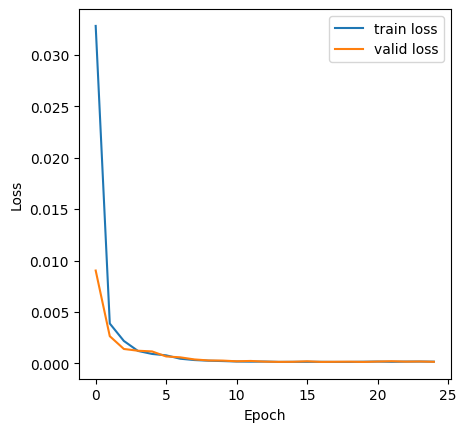

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 34
min train loss: 0.0002019179111150813
min valid loss: 0.00022296499628282618


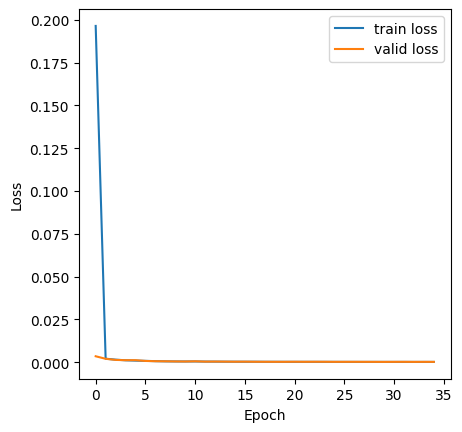

CV round 7_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 15
min train loss: 0.000142684589236248
min valid loss: 0.00016107174987586118


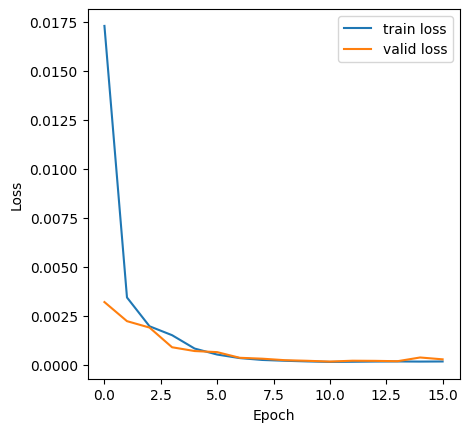

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 19
min train loss: 0.00010786453855292744
min valid loss: 0.00012170173363301728


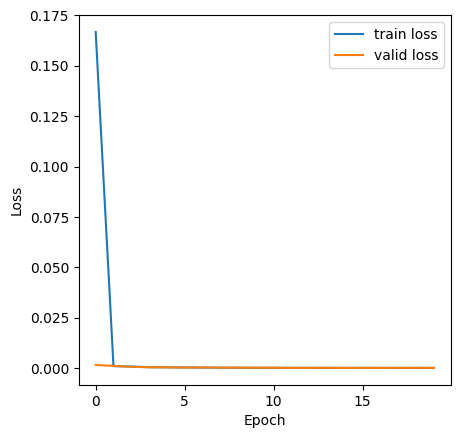

CV round 8_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 15
min train loss: 0.00013672445716524223
min valid loss: 0.00013488438956923537


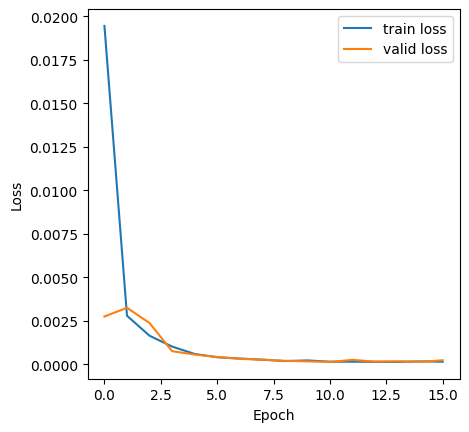

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 27
min train loss: 0.00012254741833947429
min valid loss: 0.00011334146438457537


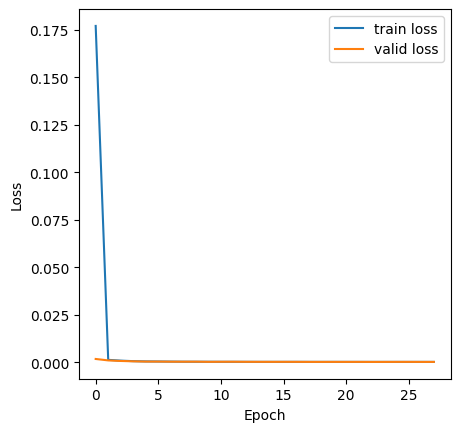

CV round 9_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 14
min train loss: 0.00014612878184187028
min valid loss: 0.00015253982450016528


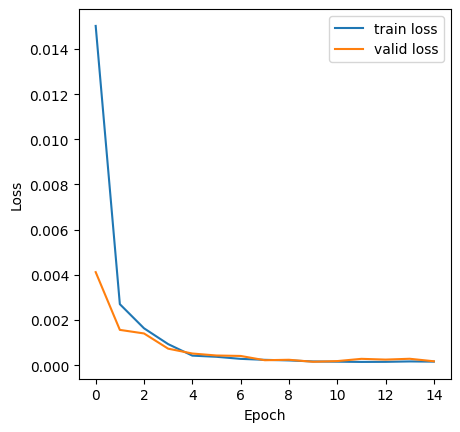

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 28
min train loss: 0.00011978840219936419
min valid loss: 0.00010280763808623306


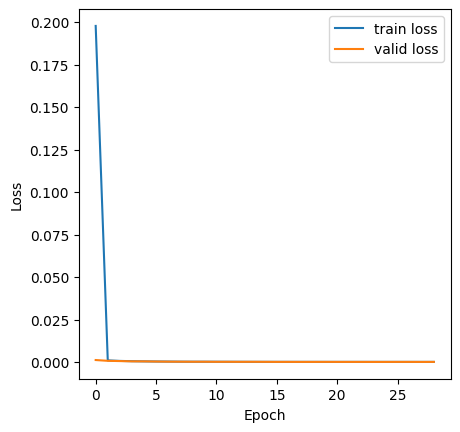

CV round 10_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 17
min train loss: 0.0001260250808930626
min valid loss: 0.00013093790441512523


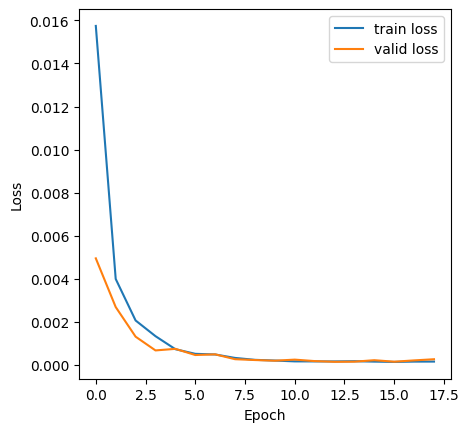

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 43
min train loss: 0.00013736446129438594
min valid loss: 0.00015173560177572654


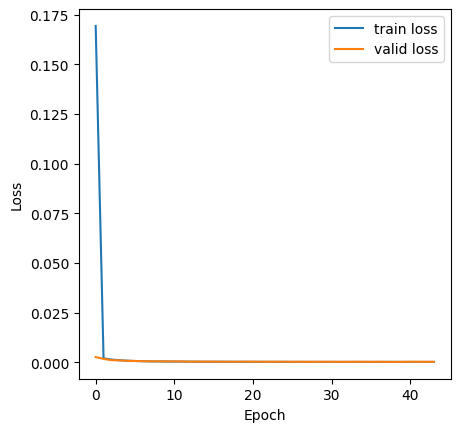

CV round 11_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 15
min train loss: 0.00014000419273405427
min valid loss: 0.00022436925983607866


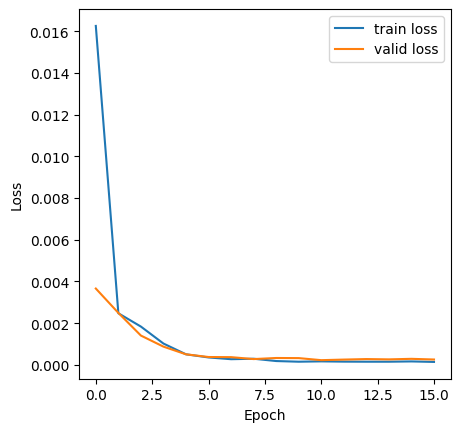

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 36
min train loss: 0.00011252003244986884
min valid loss: 0.00011245382938795956


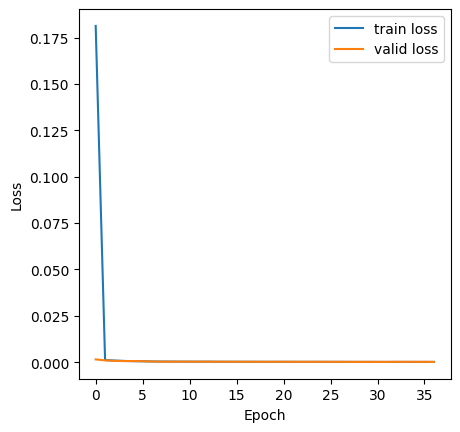

CV round 12_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 13
min train loss: 0.00013433103446335406
min valid loss: 0.00017218758914264311


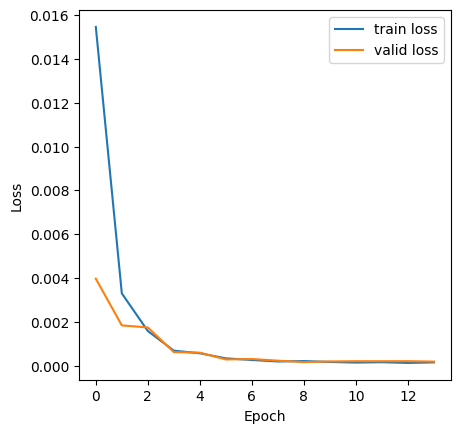

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 31
min train loss: 0.00012699825039652008
min valid loss: 0.00013755908776147407


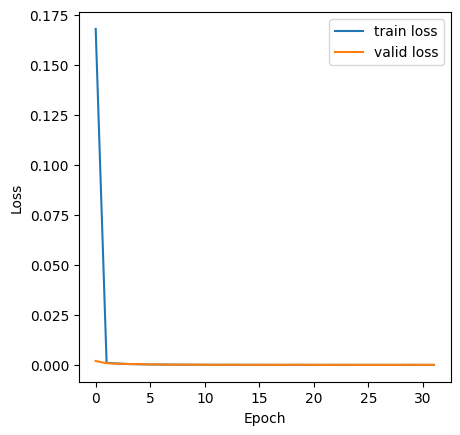

CV round 13_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 20
min train loss: 0.00012788011358541993
min valid loss: 0.00012096978638223128


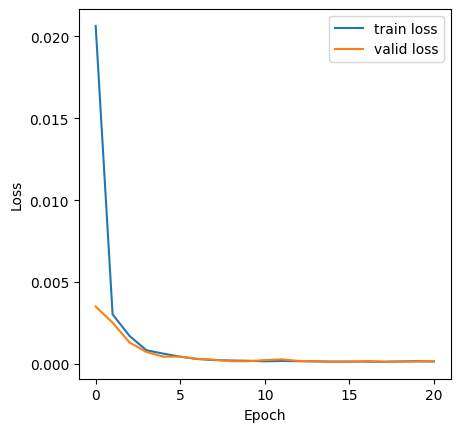

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 32
min train loss: 0.00012836873237657447
min valid loss: 0.00014147569436318008


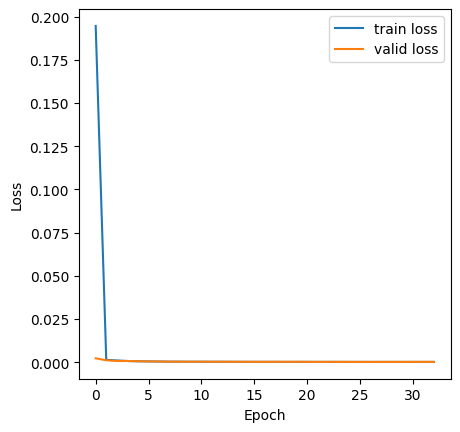

CV round 14_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 16
min train loss: 0.0001311789272663053
min valid loss: 0.00012775519931701158


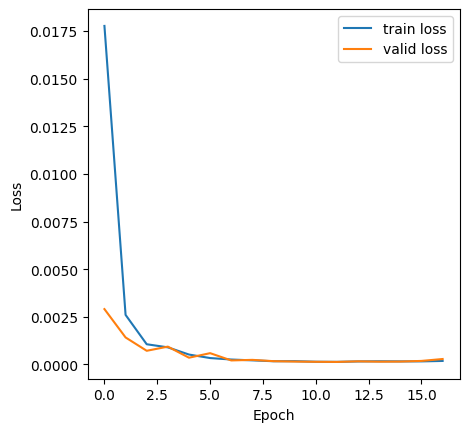

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 33
min train loss: 0.00013564890435769814
min valid loss: 0.0001263316476070031


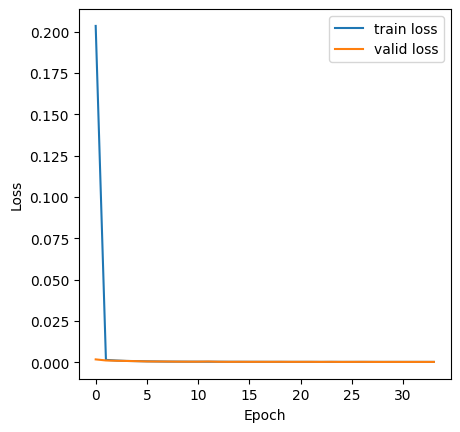

CV round 15_________________________________
using temperature_230509_discrete
EARLY STOPPING @ epoch 13
min train loss: 0.0001233709929996015
min valid loss: 0.0001399729689613818


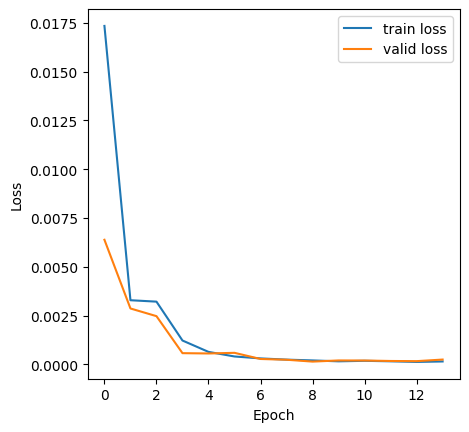

using pressure_230516_discrete
reset: train & valid loss, early stopper, saver
EARLY STOPPING @ epoch 23
min train loss: 0.00012349792976403313
min valid loss: 0.00010335592628507584


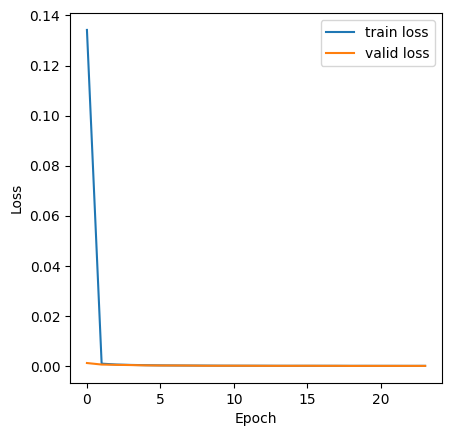



best model is: CV=5.pth with 9.223171105077199e-05
The aggregate performance is: mean 0.00013011097166781838, std 2.927312206126507e-05


In [21]:
from torch.utils.data import DataLoader
from tools import SiameseDataset, SaveBestCrossValidationModel

CV_saver = SaveBestCrossValidationModel(s['best model folder'])
test_indices = data_dictionary[s['data T']]['test indices']
epoch = s['epoch']
print(f"data: {s['data T']} then {s['data P']}")
cross_validation_loss = []
for cross_validation_round in range(s['cross validation round']):
    if cross_validation_round < s['cross validation round']:
        print(f"CV round {cross_validation_round}_________________________________")
        network_object = Manager(epoch, cross_validation_round)
        print(f"using {s['data T']}")
        _ = network_object.train(
            DataLoader(SiameseDataset(
            data_dictionary[s['data T']]['data'],
            data_dictionary[s['data T']]['label'],
            data_dictionary[s['data T']]['train indices'][cross_validation_round],
            device=device,), shuffle=False, batch_size=s['batch size']),
            DataLoader(SiameseDataset(
            data_dictionary[s['data T']]['data'],
            data_dictionary[s['data T']]['label'],
            data_dictionary[s['data T']]['valid indices'][cross_validation_round],
            device=device,), shuffle=False, batch_size=s['batch size']))
        print(f"using {s['data P']}")
        network_object._saver.reset()
        network_object._stopper.reset()
        network_object._train_loss = []
        network_object._valid_loss = []
        # reset auxiliary network
        network_object._network.auxiliary_sequential.apply(network_object.initializer)
        print(f"reset: train & valid loss, early stopper, saver, auxiliary section")
        valid_loss = network_object.train(
            DataLoader(SiameseDataset(
            data_dictionary[s['data P']]['data'],
            data_dictionary[s['data P']]['label'],
            data_dictionary[s['data P']]['train indices'][cross_validation_round],
            device=device,), shuffle=False, batch_size=s['batch size']),
            DataLoader(SiameseDataset(
            data_dictionary[s['data P']]['data'],
            data_dictionary[s['data P']]['label'],
            data_dictionary[s['data P']]['valid indices'][cross_validation_round],
            device=device,), shuffle=False, batch_size=s['batch size']))
        CV_saver(current_loss=valid_loss, round=cross_validation_round)
        cross_validation_loss.append(valid_loss)
print()
print(f"\nbest model is: {CV_saver.best_model_name} with {CV_saver.current_best_loss}")
print(f"The aggregate performance is: mean {np.mean(cross_validation_loss)}, std {np.std(cross_validation_loss)}")

In [22]:
network_object._network.load_state_dict(torch.load(s['best model folder'] + CV_saver.best_model_name))
test_loss = network_object.test(
            DataLoader(SiameseDataset(
            data_dictionary[s['data T']]['data'],
            data_dictionary[s['data T']]['label'],
            data_dictionary[s['data T']]['test indices'],
            device=device,), shuffle=False, batch_size=s['batch size']))
print(f"testing loss: for {s['data T']}: {test_loss}")
test_loss = network_object.test(
            DataLoader(SiameseDataset(
            data_dictionary[s['data P']]['data'],
            data_dictionary[s['data P']]['label'],
            data_dictionary[s['data P']]['test indices'],
            device=device,), shuffle=False, batch_size=s['batch size']))
print(f"testing loss: for {s['data P']}: {test_loss}")

testing loss: for temperature_230509_discrete: 0.33766642369722066
testing loss: for pressure_230516_discrete: 0.00011888197536791267
